## **Segmentation and Trait Extraction**
This Jupyter Notebook is a pipeline for masking processed IFCB images using the SAM model (GitHub: https://github.com/facebookresearch/segment-anything). The pipeline consists of three steps to ensure images are masked appropriately:<br>

**1- Automatic Input and Monitoring:**<br>
Inputs are automatically provided to the entire image. Use 4 corner points to assign background to images.<br>
Filter out images with scores that not meet the criteria<br>
Scores are monitored to check if images are masked appropriately.<br>
For images in flagged folder, are not masked appropriately, proceed to Step 2.<br>
**2-Automatic Input for Remaining Images:**<br>
Step 2 starts with the images in "flagged_folder"<br>
Box input is automatically provided to the model for automatic masking.<br>
Again, filter out images with scores that not meet the criteria<br>
For images in flagged folder2, proceed to Step 3.<br>
**3-Manual Input for Remaining Images:**<br>
For images that are still not masked appropriately, 'flagged folder2' a manual approach is applied.<br>
The image is plotted, and manual inputs are given.<br>
Segment them manually using green points to indicate the foreground and red points to indicate the background.<br>
Select the best mask <br>
Save the best mask<br>

**Scores**<br>
Segmentation: Proportion of image covered by the mask, 0.05<segmentation score<0.5 (for may); 0.05<seg score<1.0 (for september, october) <br>
Copmactness: Measures how compact the mask is using the ratio of perimeter squared to the area,compact score<50 <br>
Smoothness: measures the smoothness of the mask boundaries using the ratio of the perimeter to the area, smooth score <0.3 <br>



**Requirements**<br>
Python 3.8 or higher<br>
PyTorch 1.7 or higher<br>
torchvision 0.8 or higher<br>
CUDA support (GPU) for faster execution<br>

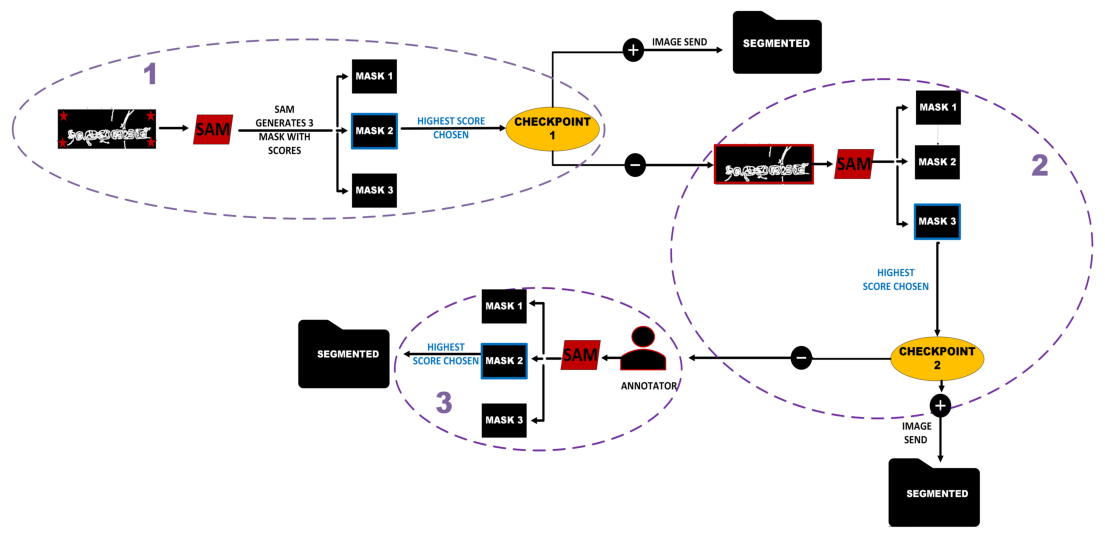

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Provide the image path on your local machine
image_path = r'C:\Users\kurta\OneDrive - UW\Desktop\IFCB-image-data-process\docs\SAM_unsupervised4.png'

# Open the image using PIL
image = Image.open(image_path)

# Display the image using Matplotlib
plt.figure(figsize=(14,14))
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()


The image above illustrates the three steps for automatic image segmentation

**Load the Model**<br>
The below cell loads the SAM (Segment Anything Model) by registering the pre-trained model from the segment_anything library. The model is initialized using the "vit_h" variant, which is a specific architecture of the SAM model. The model's weights are loaded from the checkpoint file (located at the specified path). After loading the model, a SamPredictor object is created to facilitate making predictions with the SAM model.

In [ ]:
#register the model 
from segment_anything import sam_model_registry,  SamPredictor
sam = sam_model_registry["vit_h"](checkpoint="C:/Users/kurta/Downloads/sam_vit_h_4b8939.pth")#pathway in computer where you download the model
predictor = SamPredictor(sam)

**Definitions and Functions**<br>
This cell contains several utility functions used for processing and visualizing the segmentation masks, as well as evaluating their quality:

*show_mask(mask, ax, color=[30/255, 144/255, 255/255, 0.6]):*
This function overlays a segmentation mask on an image, displaying it with a specified color (default is blue with some transparency). It helps visualize the areas covered by the mask.

*show_points(coords, labels, ax, marker_size=375):*
This function visualizes points on the image based on their coordinates and labels. It uses red stars to mark points considered background (label 0), which helps in verifying the placement of background and foreground points.

*segmentation_score(mask):*
The segmentation score is calculated by measuring the proportion of the image covered by the mask. A higher score indicates that the mask is covering more of the relevant area in the image.

*compactness(mask):*
This function evaluates the compactness of the segmentation mask by calculating the ratio of the mask's perimeter squared to its area. A lower compactness score indicates a more compact mask, which is often preferred for accurate segmentation.

*mask_smoothness(mask):*
The smoothness score is calculated by the ratio of the perimeter of the mask to its area. A lower smoothness score indicates smoother boundaries for the mask, which is desirable in many segmentation tasks to avoid jagged edges.

*get_image_corners(image):*
This function retrieves the corner points of an image, which are useful for defining the background or bounding box in segmentation tasks. The four corners of the image are returned as coordinates.

In [ ]:
#DEFINIIONS AND FUNCTIONS
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# Function to show mask
def show_mask(mask, ax, color=[30/255, 144/255, 255/255, 0.6]):  # Blue color by default
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)
    ax.imshow(mask_image)

# Function to show points
def show_points(coords, labels, ax, marker_size=375):
    neg_points = coords[labels == 0]
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

# Function to calculate segmentation score (coverage)
def segmentation_score(mask):
    return np.sum(mask) / mask.size

# Segmentation evaluation functions
def compactness(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return 0
    perimeter = np.sum([cv2.arcLength(contour, True) for contour in contours])
    area = np.sum(mask)
    if area == 0:
        return 0
    compactness_score = (perimeter ** 2) / (4 * np.pi * area)
    return compactness_score

def mask_smoothness(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return 0
    perimeter = np.sum([cv2.arcLength(contour, True) for contour in contours])
    area = np.sum(mask)
    if area == 0:
        return 0
    smoothness_score = perimeter / area
    return smoothness_score

# Helper function to get image corner points
def get_image_corners(image):
    h, w = image.shape[:2]
    return np.array([[0, 0], [0, h - 1], [w - 1, 0], [w - 1, h - 1]])


## **STEP-1** <br>
This step processes the IFCB images by applying the SAM model for segmentation. The main actions in this process include:

Configuration:

**image_folder**: Path to the folder containing the processed images.

**output_folder**: Folder where the results (segmentation masks, binary images, and plots) will be saved.

**flagged_folder**: Folder where images that fail the quality checks (segmentation score, compactness, and smoothness) will be saved.

**Image Processing**:
The code iterates over the image files in the image_folder, reads them, and converts them to RGB format.

**Automatic Masking**:
For each image, the SAM model predicts a segmentation mask based on 4 corner points that define the background. The model's predictor.predict() function generates multiple masks, and the best mask (with the highest score) is selected.

**Mask Evaluation**:
The mask is then inverted to highlight the foreground and evaluated based on three metrics:

**Segmentation Score**: Measures the proportion of the image covered by the mask.

**Compactness**: Evaluates how compact the mask is.

**Smoothness**: Measures the smoothness of the mask boundaries.

**Saving Results**:
If the mask passes the quality checks (i.e., segmentation score between 0.05 and 0.5, compactness score under 50, and smoothness score under 0.3), the mask is saved:

**npy format**: The mask is saved as a NumPy array.

**Binary image**: The mask is also saved as a binary PNG image.

Plot: A plot showing the image with the mask overlay is saved as a PNG.

Flagging:
If the mask doesn't meet the criteria, the image is saved in the flagged folder for further review.

Finally, a summary is printed, indicating how many images were processed and where the results were saved.

In [ ]:
#STEP 1


# Configuration
image_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202210\Processed_Folder\D20221001T000250_IFCB165_processed"
output_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202210\Processed_Folder\D20221001T000250_IFCB165_processed\SA4point"
flagged_folder = os.path.join(output_folder, "flagged")
os.makedirs(output_folder, exist_ok=True)
os.makedirs(flagged_folder, exist_ok=True)

# Process images
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Set the image and provide the corner points
    predictor.set_image(image_rgb)
    input_points = get_image_corners(image_rgb)
    input_labels = np.array([0, 0, 0, 0])  # All corners as background (red)

    # Predict masks using the corner points
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        box=None,
        multimask_output=True,
    )

    # Select the best mask based on the highest score
    best_mask = masks[np.argmax(scores)]

    # Invert the mask to highlight foreground instead of background
    inverted_mask = np.logical_not(best_mask).astype(np.uint8)

    # Calculate segmentation score and other metrics
    seg_score = segmentation_score(inverted_mask)
    compact_score = compactness(inverted_mask)
    smoothness_score = mask_smoothness(inverted_mask)

    # Save the mask as a numpy array if it meets the criteria
    base_filename = os.path.splitext(image_file)[0]
    if 0.05 < seg_score < 0.5 and compact_score < 50 and smoothness_score < 0.3:
        npy_output_path = os.path.join(output_folder, f"{base_filename}_masked.npy")
        np.save(npy_output_path, inverted_mask)
        
        # Save the mask as a binary image
        binary_output_path = os.path.join(output_folder, f"{base_filename}_masked.png")
        cv2.imwrite(binary_output_path, inverted_mask * 255)
        
        # Save the plot
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        show_mask(inverted_mask, plt.gca())
        show_points(input_points, input_labels, plt.gca())
        plt.axis('off')
        plt.title(f"Image: {image_file} | Seg. Score: {seg_score:.3f} | Comp: {compact_score:.2f} | Smooth: {smoothness_score:.2f}")
        plot_output_path = os.path.join(output_folder, f"{base_filename}_plot.png")
        plt.savefig(plot_output_path)
        plt.close()
    else:
        flagged_output_path = os.path.join(flagged_folder, f"{base_filename}_flagged.png")
        cv2.imwrite(flagged_output_path, inverted_mask * 255)

print(f"Processed {len(image_files)} images and saved results to {output_folder}")


## **STEP-2**:
This step processes the flagged images by providing bounding box inputs to the SAM model for automatic segmentation:

**Configuration**:
The paths for the flagged images, original images, and output directories are set. The output folder is created if it doesn't already exist.

**Process Flagged Images**:
For each flagged image, the corresponding original image is loaded. If the original image is missing, the image is skipped.

**Bounding Box Input**:
The image is passed to the SAM model with a bounding box around the entire image, and the model predicts the segmentation mask.

**Mask Refinement**:
The predicted mask is inverted to highlight the foreground, and the bounding box area is excluded from the mask (set to 0).

**Segmentation Evaluation**:
The mask is evaluated based on three criteria: segmentation score, compactness, and smoothness. If the mask meets the defined criteria, it is saved in multiple formats (NumPy array, binary image, and plot).

**Flagging**:
If the mask doesn’t meet the criteria, the image is saved in the flagged folder for further review.

In [ ]:
#STEP 2
# Configuration
flagged_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202210\Processed_Folder\D20221001T000250_IFCB165_processed\SA4point\flagged"
processed_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202210\Processed_Folder\D20221001T000250_IFCB165_processed"
output_folder = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202210\Processed_Folder\D20221001T000250_IFCB165_processed\SA4point\SAM2_box_with_scores"
flagged_output_folder = os.path.join(output_folder, "flagged")
os.makedirs(output_folder, exist_ok=True)
os.makedirs(flagged_output_folder, exist_ok=True)

# Process images
flagged_files = [f for f in os.listdir(flagged_folder) if f.endswith('.png')]
for flagged_file in flagged_files:
    # Find the corresponding original image in the processed folder
    base_filename = os.path.splitext(flagged_file)[0].replace('_flagged', '')
    image_path = os.path.join(processed_folder, base_filename + '.png')
    
    if not os.path.exists(image_path):
        print(f"Original image not found for {flagged_file}")
        continue

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Set the image and provide bounding box
    predictor.set_image(image_rgb)

    # Get image dimensions to create a bounding box
    image_height, image_width = image_rgb.shape[:2]
    input_box = np.array([0, 0, image_width, image_height])  # [x1, y1, x2, y2]

    # Predict masks using the bounding box
    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=True,
    )

    # Select the mask with the highest score
    best_mask_index = np.argmax(scores)
    best_mask = masks[best_mask_index]
    best_score = scores[best_mask_index]

    # Invert the mask to highlight foreground instead of background
    inverted_mask = np.logical_not(best_mask).astype(np.uint8)

    # Exclude the bounding box from the mask (set the bounding box area to 0)
    inverted_mask[:input_box[1], :] = 0  # Top
    inverted_mask[input_box[3]:, :] = 0  # Bottom
    inverted_mask[:, :input_box[0]] = 0  # Left
    inverted_mask[:, input_box[2]:] = 0  # Right

    # Calculate segmentation score and other metrics
    seg_score = segmentation_score(inverted_mask)
    compact_score = compactness(inverted_mask)
    smoothness_score = mask_smoothness(inverted_mask)

    # Save the mask if it meets the criteria
    if 0.05 < coverage < 0.5 and compact_score < 50 and smoothness_score < 0.3:
        npy_output_path = os.path.join(output_folder, f"{base_filename}_masked.npy")
        np.save(npy_output_path, inverted_mask)
        
        # Save the mask as a binary image
        binary_output_path = os.path.join(output_folder, f"{base_filename}_masked.png")
        cv2.imwrite(binary_output_path, inverted_mask * 255)
        
        # Save the plot
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        show_mask(inverted_mask, plt.gca())
        plt.axis('off')
        plt.title(f"Image: {base_filename}.png | Mask Score: {best_score:.3f}")
        plot_output_path = os.path.join(output_folder, f"{base_filename}_plot.png")
        plt.savefig(plot_output_path)
        plt.close()
    else:
        flagged_output_path = os.path.join(flagged_output_folder, f"{base_filename}_flagged.png")
        cv2.imwrite(flagged_output_path, inverted_mask * 255)

print(f"Processed {len(flagged_files)} images and saved results to {output_folder}")


Processed 60 images and saved results to D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202210\Processed_Folder\D20221001T000250_IFCB165_processed\SA4point\SAM2_box_with_scores


## **STEP-3.1**<br>
This step visualizes the image by plotting it in matplotlib with axis coordinates enabled:

**Load Image**:
The image is loaded from the specified path using cv2.imread, and then it is converted to RGB using cv2.cvtColor because OpenCV loads images in BGR format by default, but matplotlib expects RGB.<br>
**Plot the Image**:
The image is displayed using plt.imshow, and plt.axis('on') ensures that the axis coordinates (x and y) are visible, which can be helpful for pinpointing locations in the image. The plot is displayed using plt.show().<br>

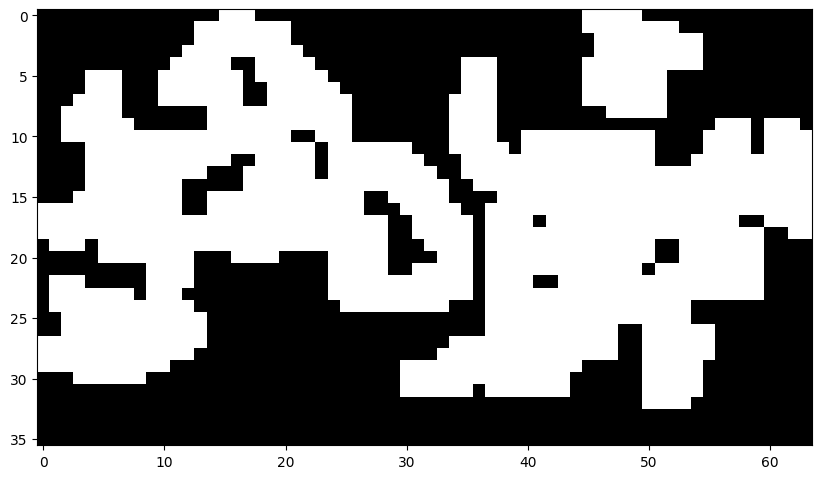

In [2]:
#STEP 3.1-PLOT THE IMAGE
import cv2
import matplotlib.pyplot as plt

# Configuration
image_path = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202210\Processed_Folder\D20221001T000250_IFCB165_processed\D20221001T000250_IFCB165.00104.png"

# Load the image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image with axis coordinates
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('on')
plt.show()


## **STEP 3-2**<br>
This step visualizes the input points that were defined for the segmentation process, highlighting the foreground and background points:

**Input Points and Labels**:
The input_points array contains the coordinates for the foreground (green star) and background (red star) points. The input_labels array assigns 1 to the foreground and 0 to the background.

**show_points() Function**:
This function displays the points on the image, using green stars for foreground points and red stars for background points. It uses ax.scatter to plot the points with specific styles (color, size, edge color, etc.).

**Plotting the Image with Points**:
The image is displayed with plt.imshow(image_rgb), and the input points are plotted on top using show_points(). This step ensures that the user can verify the placement of foreground and background points before moving on to segmentation.

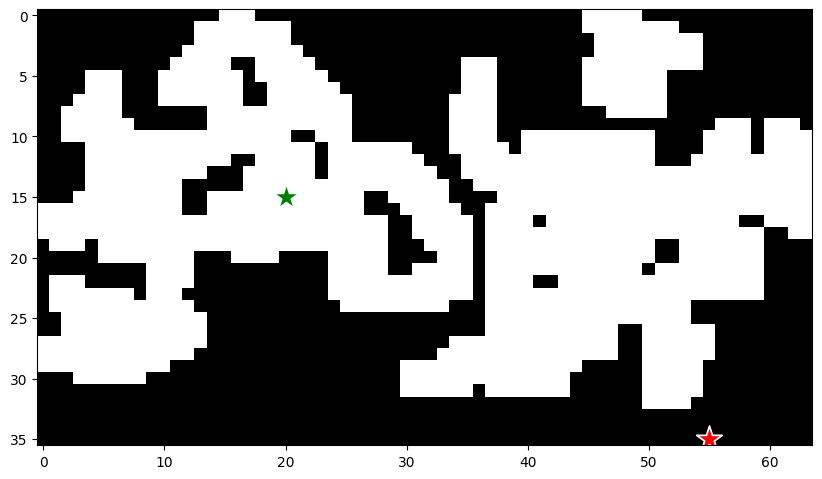

In [ ]:
#3.2-PLOT THE INPUT TO VERIFY
#Green star foreground,red star background
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Define input points and labels
input_points = np.array([[20, 15], [55, 35]])
input_labels = np.array([1, 0])  # First point as foreground (green), second as background (red)

# Function to show points
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

# Plot the image with the input points
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
show_points(input_points, input_labels, plt.gca())
plt.axis('on')
plt.show()




The below cell prepares the image for segmentation by setting the image that the SAM model (Segment Anything Model) will process. It essentially tells the model to use the given image (in RGB format) for subsequent predictions.

In [ ]:
predictor.set_image(image_rgb)#ran the model

## **STEP-3.2**<br>
In this step, the model’s predictions are visualized by plotting the generated masks alongside the original image and the input points.

**Model Prediction**:
The SAM model is applied to the image with the specified input points (foreground and background) and labels (foreground and background). The predictor.predict() method is used to generate multiple masks, which are stored in the masks array. The multimask_output=True option allows the model to generate multiple possible masks.

**Displaying Masks**:
A function show_mask() is defined to overlay the masks on the image. The masks are displayed with a blue color by default, but the opacity is controlled via the color[3] value (mask transparency).

**Plotting**:

The original image is displayed along with the input points (foreground and background).<br>
Then, three generated masks are overlaid on the image, allowing you to visually inspect the segmentation results from the model.<br>
The images are shown in a 1x4 grid, with each subplot displaying one image, the first showing the original image with points, and the others showing the image with each of the three masks.<br>

**Final Visualization**:
The result is a visualization of how well the model's predicted masks match the intended segmentation, enabling you to review and choose the best mask.

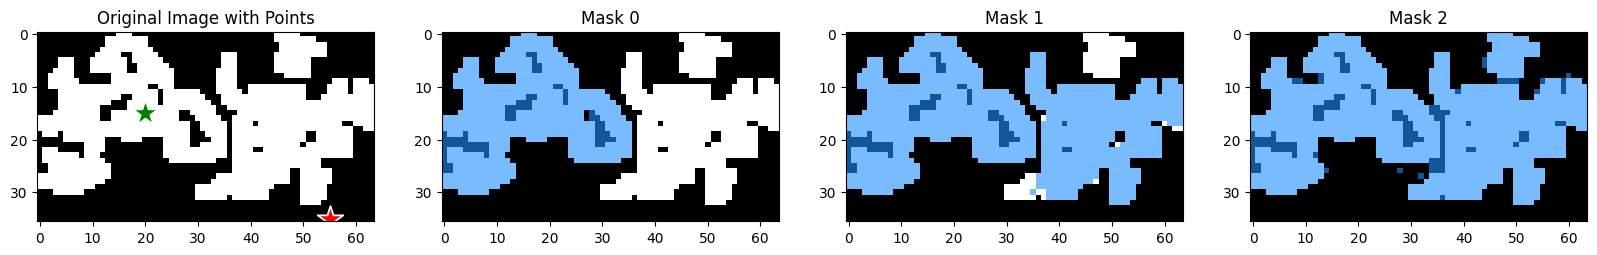

In [ ]:
#3.3-GIVE MODEL PREDICTION INPUT AND PLOT THE MASKS for SELECTION
# Apply the predictor to get the masks
masks, _, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)

# Function to show mask
def show_mask(mask, ax, color=[30/255, 144/255, 255/255, 0.6]):  # Blue color by default
    h, w = mask.shape[-2:]
    mask_image = np.zeros((h, w, 4))
    mask_image[..., :3] = np.array(color[:3])
    mask_image[..., 3] = mask * color[3]
    ax.imshow(mask_image)

# Display the image with points and the resulting masks
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

# Original image with points
axs[0].imshow(image_rgb)
show_points(input_points, input_labels, axs[0])
axs[0].set_title("Original Image with Points")
axs[0].axis('on')

# Image with the generated masks
for i in range(3):
    axs[i + 1].imshow(image_rgb)
    show_mask(masks[i], axs[i + 1])
    axs[i + 1].set_title(f"Mask {i}")
    axs[i + 1].axis('on')

plt.show()

## **Save the Best Mask**<br>
This step saves the manually chosen mask after visual inspection and selection. Here’s a breakdown of the process:

**Configuration**:

The save_path is defined to specify where the output files will be stored (including .npy files, binary images, and plots).<br>
Directories are created if they don't already exist using os.makedirs.<br>

**Selecting the Mask**:

The selected mask is chosen by its index in the masks array. In this case, the mask with index 2 is selected for saving.

**Saving the Mask**:

**The mask is saved in three formats**:

NumPy Array (.npy): The selected mask is saved as a .npy file for efficient storage and access.

Binary Image (.png): The mask is saved as a binary image where pixels corresponding to the foreground are set to 255 (white) and the background is black.

**Saving the Mask with Blue Overlay**:

The function save_mask_with_overlay saves a plot showing the image with the mask overlaid in blue. It also includes the segmentation score and the selected score in the title.

The plot is saved as a PNG file showing the overlaid mask and the model’s performance.

**Printing the Result**:
After saving the files, a confirmation message is printed with the location where the results are stored.

In [ ]:
#SAVES THE MASKS THE MANUALLY CHOSEN 
#Saves it as numpy, masked png, and blue-masked png
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Configuration
save_path = r"D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202210\Processed_Folder\D20221001T000250_IFCB165_processed\SA4point\SAM2_box_with_scores\flagged\SAM_manual"
os.makedirs(save_path, exist_ok=True)

# Select the mask with index 2
mask_index = 2
selected_mask = masks[mask_index]
selected_score = scores[mask_index]

# Ensure the directories exist
os.makedirs(save_path, exist_ok=True)

# Save the mask as a numpy array
base_filename = os.path.splitext(os.path.basename(image_path))[0]
npy_output_path = os.path.join(save_path, f"{base_filename}_masked.npy")
np.save(npy_output_path, selected_mask)

# Save the mask as a binary image
binary_output_path = os.path.join(save_path, f"{base_filename}_masked.png")
cv2.imwrite(binary_output_path, (selected_mask * 255).astype(np.uint8))

# Save the mask with a blue overlay and score
def save_mask_with_overlay(image, mask, score, output_path):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    h, w = mask.shape[-2:]
    mask_image = np.zeros((h, w, 4))
    mask_image[..., :3] = np.array([30/255, 144/255, 255/255])  # Blue color
    mask_image[..., 3] = mask * 0.6  # Alpha channel
    ax.imshow(mask_image)
    seg_score = segmentation_score(mask)
    ax.set_title(f"Mask 2 | Score: {score:.3f} | Seg. Score: {seg_score:.3f}")
    ax.axis('off')
    plt.savefig(output_path)
    plt.close()

plot_output_path = os.path.join(save_path, f"{base_filename}_masked.png")
save_mask_with_overlay(image_rgb, selected_mask, selected_score, plot_output_path)

print(f"Saved mask 2 as .npy and .png with score to {save_path}")



Saved mask 2 as .npy and .png with score to D:\EndSeason-DataDump22\DY22_06_IFCB\images_2022\D202210\Processed_Folder\D20221001T000250_IFCB165_processed\SA4point\SAM2_box_with_scores\flagged\SAM_manual
